In [1]:
%matplotlib inline

from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import SHS_data
import util
import paired_data

reload(paired_data);

## Learning cover song fingerprints

### Data

#### load train and test data

In [2]:
ratio = (24,1,75)
clique_dict, _ = SHS_data.read_cliques()
train_cliques, test_cliques, _ = util.split_train_test_validation(clique_dict, ratio=ratio)

print('Preloading training data...')
train_uris = util.uris_from_clique_dict(train_cliques)
chroma_dict = SHS_data.preload_chroma(train_uris)

print('Preparing training dataset...')
n_patches, patch_len = 8, 64
X_A, X_B, Y, pair_uris = paired_data.dataset_of_pairs(train_cliques, chroma_dict,
                                                             n_patches=n_patches, patch_len=patch_len)
print('    Training set:', X_A.shape, X_B.shape, Y.shape)

print('Preloading test data...')
test_uris = util.uris_from_clique_dict(test_cliques)
chroma_dict_T = SHS_data.preload_chroma(test_uris)

print('Preparing test dataset...')
X_A_T, X_B_T, Y_T, test_pair_uris_T = paired_data.dataset_of_pairs(test_cliques, chroma_dict_T,
                                                             n_patches=n_patches, patch_len=patch_len)
print('    Test set:', X_A_T.shape, X_B_T.shape, Y_T.shape)

Preloading training data...
Preparing training dataset...
    Training set: (17630, 512, 12) (17630, 512, 12) (17630,)
Preloading test data...
Preparing test dataset...
    Test set: (664, 512, 12) (664, 512, 12) (664,)


#### batch generator

In [3]:
def get_batches(arrays, batch_size=50):
    """Batch generator, no shuffling.
    
    Args:
        arrays (list): list of arrays. Arrays should have equal length
        batch_size (int): number of examples per batch
        
    Yields:
        list: list of batches of length batch_size
        
    Usage:
    >>> batches = get_batches([X, Y], batch_size=50)
    >>> x, y = batches.next()
    """
    array_lengths = [len(array) for array in arrays]
    n_examples = array_lengths[0]
    if not np.all(np.array(array_lengths) == n_examples):
        raise ValueError('Arrays must have the same length.')
    start = 0
    while True:
        start = np.mod(start, n_examples)
        stop = start + batch_size
        batch = [np.take(array, range(start, stop), axis=0, mode='wrap') for array in arrays]
        start = stop
        yield batch
        
# # test
# x = np.arange(100)
# y = x + 1988
# batches = get_batches([x, y], batch_size=7)
# for i in range(20):
#     print(next(batches))

### Tensorflow shorthands

#### variables

In [4]:
weight_scale = 0.1 # 0.1

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=weight_scale)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(weight_scale, shape=shape)
    return tf.Variable(initial)

#### layers

In [5]:
def conv_bins(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def conv_frames(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_4x1(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 1, 1],
                          strides=[1, 4, 1, 1], padding='SAME')

def max_pool_8x1(x):
    return tf.nn.max_pool(x, ksize=[1, 8, 1, 1],
                          strides=[1, 8, 1, 1], padding='SAME')

def max_pool_64x1(x):
    return tf.nn.max_pool(x, ksize=[1, 64, 1, 1],
                          strides=[1, 64, 1, 1], padding='SAME')

### Network

#### input

In [6]:
input_len = n_patches * patch_len

x_A = tf.placeholder("float", shape=[None, input_len, 12])
x_B = tf.placeholder("float", shape=[None, input_len, 12])
y_ = tf.placeholder("float", shape=[None,])

x_image_A = tf.reshape(x_A, [-1, input_len, 12, 1])
x_image_B = tf.reshape(x_B, [-1, input_len, 12, 1])
y_ = tf.reshape(y_, [-1, 1])

#### conv layer 1

`(512, 12, 1) > (512, 1, 32)`

In [7]:
W_conv1 = weight_variable([1, 12, 1, 64])
b_conv1 = bias_variable([64])

h_conv1_A = tf.nn.relu(conv_bins(x_image_A, W_conv1) + b_conv1)
h_conv1_B = tf.nn.relu(conv_bins(x_image_B, W_conv1) + b_conv1)

#### conv layer 2

`(512, 1, 32) > (64, 1, 64)`

`64x1` max-pooling is used to pool at once across the last convolution (`8x1`) and the `8` patches of chroma of which the input features is made.

In [9]:
W_conv2 = weight_variable([8, 1, 64, 128])
b_conv2 = bias_variable([128])

h_conv2_A = tf.nn.relu(conv_frames(h_conv1_A, W_conv2) + b_conv2)
h_conv2_B = tf.nn.relu(conv_frames(h_conv1_B, W_conv2) + b_conv2)

h_pool1_A = max_pool_8x1(h_conv2_A)
h_pool1_B = max_pool_8x1(h_conv2_B)

#### conv layer 3

`(64, 1, 64) > (8, 1, 128)`

`8x1` pooling, leaving 

8 patches, 128 filter activations per patch

In [13]:
W_conv3 = weight_variable([8, 1, 128, 256])
b_conv3 = bias_variable([256])

# applied in next cell as activation function differs

#### architecture I: only convolutional layers

`(8, 1, 128) > (128)`

max-pool over patches and flatten

In [14]:
# h_conv3_A = tf.tanh(conv_frames(h_pool1_A, W_conv3) + b_conv3)
# h_conv3_B = tf.tanh(conv_frames(h_pool1_B, W_conv3) + b_conv3)

# h_pool2_A = max_pool_64x1(h_conv3_A)
# h_pool2_B = max_pool_64x1(h_conv3_B)

# h_pool2_A_flat = tf.reshape(h_pool2_A, [-1, 128])  # flatten images first
# h_pool2_B_flat = tf.reshape(h_pool2_B, [-1, 128])

# out_I_A = tf.tanh(h_pool2_A_flat)
# out_I_B = tf.tanh(h_pool2_B_flat)

#### archictecture II: 256 unit fully connected layer

In [16]:
h_conv3_A = tf.nn.relu(conv_frames(h_pool1_A, W_conv3) + b_conv3)
h_conv3_B = tf.nn.relu(conv_frames(h_pool1_B, W_conv3) + b_conv3)

h_pool3_A = max_pool_8x1(h_conv3_A)
h_pool3_B = max_pool_8x1(h_conv3_B)

h_pool3_A_flat = tf.reshape(h_pool3_A, [-1, 8*256])  # flatten images first
h_pool3_B_flat = tf.reshape(h_pool3_B, [-1, 8*256])

W_fc1 = weight_variable([8*256, 512])
b_fc1 = bias_variable([512])

out_II_A = tf.nn.relu(tf.matmul(h_pool3_A_flat, W_fc1) + b_fc1)
out_II_B = tf.nn.relu(tf.matmul(h_pool3_B_flat, W_fc1) + b_fc1)

#### architecture III: extra fully connected hashing layer

apply drop-out to previous layer first

In [17]:
keep_prob = tf.placeholder("float")

# h_fc1_A_drop = tf.nn.dropout(h_fc1_A, keep_prob)
# h_fc1_B_drop = tf.nn.dropout(h_fc1_B, keep_prob)

# W_fc2 = weight_variable([256, 16])
# b_fc2 = bias_variable([16])

# out_III_A = tf.nn.tanh(tf.matmul(h_fc1_A_drop, W_fc2) + b_fc2)
# out_III_B = tf.nn.tanh(tf.matmul(h_fc1_B_drop, W_fc2) + b_fc2)

#### Bhattacharyya distance

In [18]:
def approx_bhattacharyya(squared_dists, is_cover):
    """Approximate bhattacharyya distance between cover and non-cover distances.
    
    Similar to Mahalanobis distance, but for distributions with different variances.
    Assumes normality, hence approximate (distances are bound by 0).
    """
    pair_dists = np.sqrt(squared_dists[np.where(is_cover==1)])
    non_pair_dists = np.sqrt(squared_dists[np.where(is_cover==0)])
    
    mu_pairs, sigma2_pairs = np.mean(pair_dists), np.var(pair_dists)
    mu_non_pairs, sigma2_non_pairs = np.mean(non_pair_dists), np.var(non_pair_dists)

    bhatt = (0.25 * np.log(0.25 * (sigma2_pairs/sigma2_non_pairs + sigma2_non_pairs/sigma2_pairs + 2)) +
             0.25 * (mu_pairs - mu_non_pairs)**2 / (sigma2_pairs + sigma2_non_pairs))
    return bhatt, mu_pairs, mu_non_pairs

### Training

#### objective function

Minize pair distances while maximizing non-pair distances smaller than `m`

Following [1].

1. Raffel, C., & Ellis, D. P. W. (2015). Large-Scale Content-Based Matching of Midi and Audio Files. Proceedings of the 16th International Society for Music Information Retrieval Conference (ISMIR), 234–240.

In [19]:
alpha = 1
m = 10 # e.g., sqrt(256)

squared_errors = tf.reduce_sum(tf.square(out_II_A - out_II_B), reduction_indices=1, keep_dims=True)
pair_loss = tf.reduce_mean(y_ * squared_errors)
non_pair_loss = tf.reduce_mean((1 - y_) * tf.square(tf.maximum(0.0, m - tf.sqrt(squared_errors))))

loss_function = pair_loss + alpha * non_pair_loss
loss_float = tf.cast(loss_function, "float")

# optimizer
learning_rate = tf.placeholder(tf.float32, shape=[])
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)
# train_step = tf.train.RMSPropOptimizer(learning_rate, decay=0.9).minimize(loss_function)

#### init basic logging

In [20]:
error_pairs_log = []
error_non_pairs_log = []

squared_dists_log = []
labels_log = []
d_pairs_log = []
d_non_pairs_log = []

train_error_log = []
train_bhatt_log = []

test_error_log = []
test_bhatt_log = []

#### reporting

bundle all logging and printing into a function

In [21]:
def report(step, batch):
    print('step {}'.format(step))

    # train and test feeds
    train_feed = {x_A:batch[0], x_B:batch[1], y_: batch[2], keep_prob: 1.0}
    test_feed = {x_A:X_A_T, x_B:X_B_T, y_: Y_T, keep_prob: 1.0}
    
    # train metrics
    error_pairs, error_non_pairs, squared_dists, train_error = sess.run([pair_loss, non_pair_loss,
                                                                        squared_errors, loss_float],
                                                                        feed_dict=train_feed)
    train_bhatt, d_pairs, d_non_pairs = approx_bhattacharyya(squared_dists, train_feed[y_])
    
    # test metrics
    test_squared_dists, test_error = sess.run([squared_errors, loss_float],
                                              feed_dict=test_feed)
    test_bhatt, _, _ = approx_bhattacharyya(test_squared_dists, test_feed[y_])

    # log all metrics
    error_pairs_log.append(error_pairs)
    error_non_pairs_log.append(error_non_pairs)
    squared_dists_log.append(squared_dists)
    labels_log.append(batch[2])
    d_non_pairs_log.append(d_non_pairs)
    d_pairs_log.append(d_pairs)
    train_bhatt_log.append(train_bhatt)
    train_error_log.append(train_error)
    test_bhatt_log.append(test_bhatt)    
    test_error_log.append(test_error)
    
    # print some metrics
    print('  d_pairs, d_non_pairs = %.3g, %.3g' % (d_pairs, d_non_pairs))
    print('  train error %.3g, train bhatt %.3g' % (train_error, train_bhatt))
    print('  test error %.3g, test bhatt %.3g' % (test_error, test_bhatt))

#### init session

In [22]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

#### train

In [23]:
n_epoques = 1250 # 1000 ~ 4 x tests set of 50% of all data
lr = 0.0001

train_batches = get_batches([X_A, X_B, Y], batch_size=100)
for step in range(n_epoques):  
    batch = next(train_batches)
    if step%10 == 0:
        report(step, batch)
    train_feed = {x_A:batch[0], x_B:batch[1], y_: batch[2], keep_prob: 0.5, learning_rate: lr}
    train_step.run(feed_dict=train_feed)
report('[end]', batch)

step 0
  d_pairs, d_non_pairs = 11.5, 13.1
  train error 77.5, train bhatt 0.137
  test error 84.7, test bhatt 0.0428
step 10
  d_pairs, d_non_pairs = 9.02, 9.7
  train error 45, train bhatt 0.0734
  test error 45.7, test bhatt 0.041
step 20
  d_pairs, d_non_pairs = 7.9, 8.03
  train error 34.3, train bhatt 0.0294
  test error 35, test bhatt 0.0337
step 30
  d_pairs, d_non_pairs = 6.72, 7.17
  train error 29.5, train bhatt 0.0418
  test error 30.4, test bhatt 0.031
step 40
  d_pairs, d_non_pairs = 6.36, 6.83
  train error 28.4, train bhatt 0.0339
  test error 27.9, test bhatt 0.0315
step 50
  d_pairs, d_non_pairs = 5.93, 6.16
  train error 26.4, train bhatt 0.0345
  test error 26.8, test bhatt 0.0293
step 60
  d_pairs, d_non_pairs = 5.93, 6.15
  train error 26.4, train bhatt 0.0184
  test error 26.1, test bhatt 0.0267
step 70
  d_pairs, d_non_pairs = 5.56, 5.8
  train error 25.8, train bhatt 0.032
  test error 25.7, test bhatt 0.0265
step 80
  d_pairs, d_non_pairs = 4.88, 5.28
  train 

#### plot loss function 

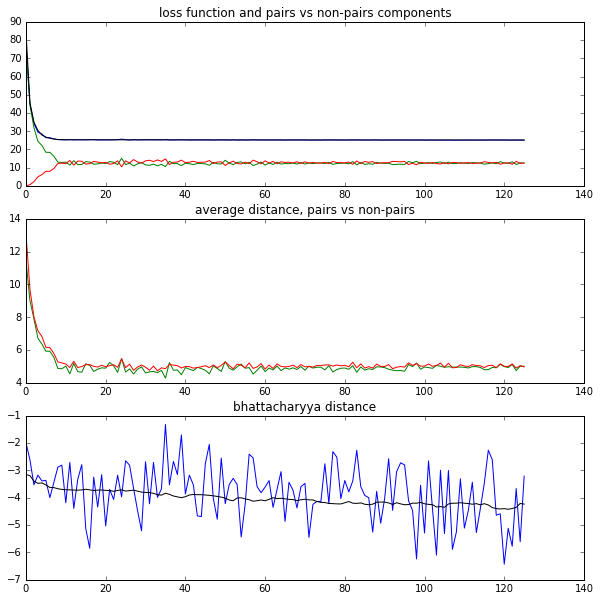

In [24]:
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.plot(train_error_log);
plt.plot(error_pairs_log, color='g');
plt.plot(error_non_pairs_log, color='r');
plt.plot(test_error_log, color='k');
plt.title('loss function and pairs vs non-pairs components');

plt.subplot(312)
plt.plot(d_pairs_log, color='g');
plt.plot(d_non_pairs_log, color='r');
plt.title('average distance, pairs vs non-pairs');

plt.subplot(313)
plt.plot(np.log(train_bhatt_log));
plt.plot(np.log(test_bhatt_log), 'k');
plt.title('bhattacharyya distance');

#### train distances

bhatt = (0.040415121093528732, 5.0074825, 4.9721627)


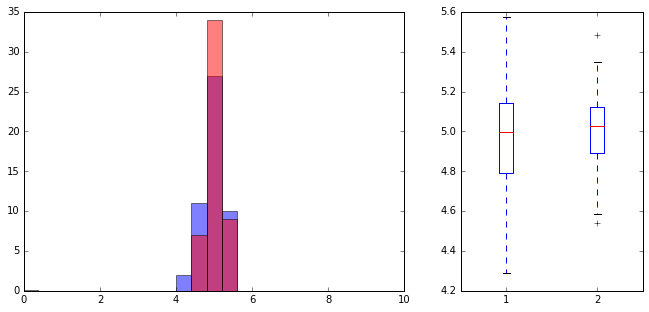

In [25]:
pair_dists = np.sqrt(squared_dists_log[-1][np.where(labels_log[-1]==1)])
non_pair_dists = np.sqrt(squared_dists_log[-1][np.where(labels_log[-1]==0)])
L1 = pair_loss.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_:batch[2], keep_prob: 1.0})
L2 = non_pair_loss.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_:batch[2], keep_prob: 1.0})

bins = np.arange(0,10,0.4)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(non_pair_dists, bins=bins, alpha=0.5);
plt.hist(pair_dists, bins=bins, color='r', alpha=0.5);
plt.subplot(143)
plt.boxplot([non_pair_dists, pair_dists]);

print('bhatt =', approx_bhattacharyya(squared_dists_log[-1], labels_log[-1]))

#### test distances

bhatt = (0.014522125594975593, 4.8732686, 5.0141454)


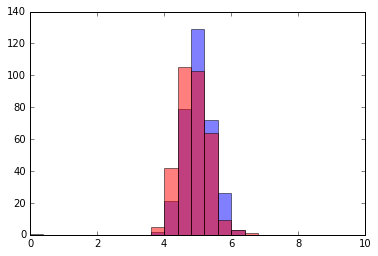

In [26]:
test_squared_dists = squared_errors.eval(feed_dict={x_A:X_A_T, x_B:X_B_T, keep_prob: 1.0})
test_squared_dists = np.sum(test_squared_dists, axis=1)

test_pair_dists = np.sqrt(test_squared_dists[np.where(Y_T==1)[0]])
test_non_pair_dists = np.sqrt(test_squared_dists[np.where(Y_T==0)[0]])

bins = np.arange(0,10,0.4)
plt.figure()
plt.hist(test_non_pair_dists, bins=bins, alpha=0.5);
plt.hist(test_pair_dists, bins=bins, color='r', alpha=0.5);

print('bhatt =', approx_bhattacharyya(test_squared_dists, Y_T))

### Test

In [27]:
# # subset
# test_subset = {uri: test_cliques[uri] for uri in test_cliques.keys()[:200]}

# print('Preloading chroma...')
# test_uris = util.uris_from_clique_dict(test_subset)
# chroma_dict_T = SHS_data.preload_chroma(test_uris)

# print('Collecting test dataset...')
# X_A_T, X_B_T, is_cover_T, test_pair_uris_T = paired_data.dataset_of_pairs(test_subset, chroma_dict_T,
#                                                              n_patches=n_patches, patch_len=patch_len)
# print(X_A_T.shape, X_B_T.shape, is_cover_T.shape)

# Y_T = is_cover_T.astype(float)